## Transformer

기존의 seq2seq 모델의 한계
- 입력 시퀀스를 하나의 벡터표현으로 압축 (context vector) 디코더는 이를 통해 출력 시퀀스를 만들어냄
- 정보가 일부 손실된다는 단점

- $d_{model}$ = 512
- num_layers = 6
- num_heads = 8
- $d_{ff}$ = 2048

### 포지셔널 인코딩

$$PE_(pose, 2i) = sin(pos/1000^{2i/d_{model}})$$
$$PE_(pose, 2i+1) = cos(pos/1000^{2i/d_{model}})$$

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


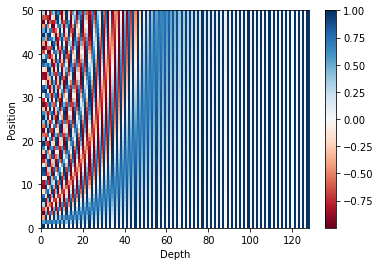

In [ ]:
# 50x 128크기를 가지는 포지셔널 인코딩 행렬을 시각화하기
# 입력문자의 단어가 50 각 단어가 128차원의 임베딩 벡터를 가질 때 사용하는 행렬

sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap = "RdBu")
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링 : dk의 루트값으로 나눈다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk /tf.math.sqrt(depth)

    # 마스킹 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weight = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이 , d_model/num_heads)
    output = tf.matmul(attention_weight, value)

    return output, attention_weight

In [ ]:
# scaled_dot_product_attention함수가 정상적으로 작동하는지 테스트 !
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype = tf.float32) # (1, 3)

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# scaled_dot_product_attention함수가 정상적으로 작동하는지 테스트 !
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 0, 10]], dtype = tf.float32) # (1, 3)

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                     [0, 0, 10],
                     [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[  1, 0],
                     [  10, 0],
                     [ 100, 5],
                     [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype = tf.float32) # (1, 3)

In [ ]:
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포
print(temp_out) # 어텐션 값

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 멀티-헤드 어텐션

![](https://wikidocs.net/images/page/31379/transformer17.PNG)

병렬 어텐션의 효과?


머리가 여러개이기 때문에, 여러 시점에서 상대방을 볼 수있다.

1. $W_Q, W_k, W_v$에 해당하는 $d_{model}$크기의 밀집층(Dense layer)을 지남
2. 지정된 헤드 수 (num_heads)만큼 나눈다.
3. 스케일드 닷 프로덕트 어텐션
4. 나눠졌던 헤드들을 연결한다.
5. $W_0$에 해당하는 밀집층을 지나게 된다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

### 패딩 마스크

![](https://wikidocs.net/images/page/31379/pad_masking2.PNG)

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### 포지션 와이드 피드 포워드 신경망

```
outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
outpus = tf.kears.layers.Dense(units=d_model)(outpus)
```

### 인코더 구현하기

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.layers.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 쌓기

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.layers.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더의 첫번째 서브층 : self 어텐션과 룩-헤드 마스크

- 인코더에 있는 self어텐션 : 패딩마스크전달
- 디코더와 첫번째 서브층인 masked self attention : 룩-어헤드 마스크전달
- 디코더의 두번째 서브층인 인코더-디코더 어텐션 : 패딩마스크전달

In [ ]:
# 디코더의 첫번째 서브층에서 미래 토큰을 mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1-tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x) # 패딩 마스크 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 디코더의 두번째 서브층 : 인코더-디코더 어텐션
- 인코더의 첫번째 서브층 : Query = Key = Value
- 디코더의 첫번쨰 서브층 : Query = Key = Value
- 디코더의 두번째 서브층 : Query(디코더행렬) // key= value (인코더행렬)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.layers.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.layers.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.layers.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.layers.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.layers.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.layers.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 트랜스포머 구현하기 

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.layers.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.layers.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(1, 9000, 128)
(1, 9000, 128)


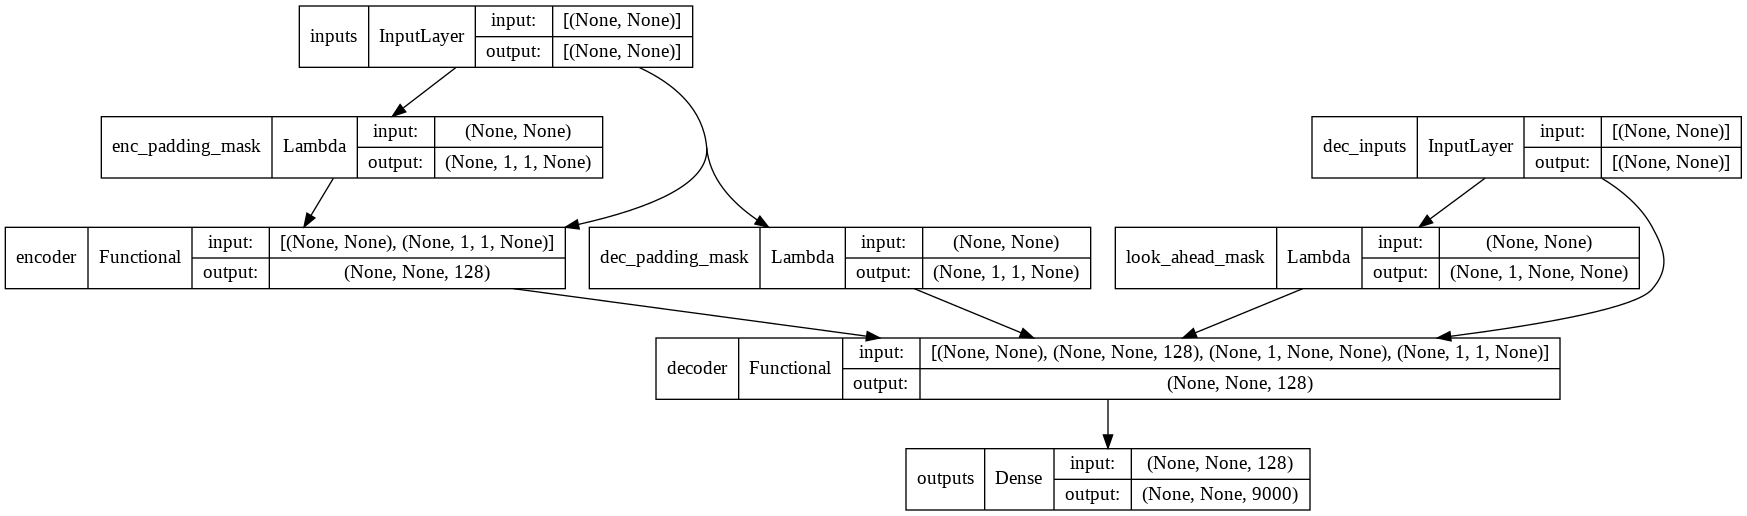

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name = "small_transformer"
)

tf.keras.utils.plot_model(
    small_transformer, to_file="small_transformer.png", show_shapes=True
)

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_length-1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

$$ lr = d_{model}^{-0.5} \times  min(stepnum^{-0.5}, stepnum \times warmupsteps^{-1.5})$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

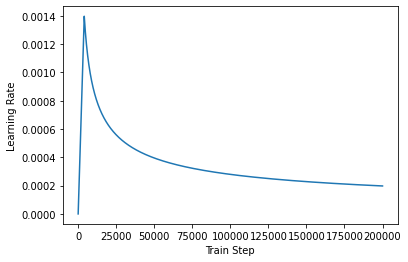

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 트랜스포머를 이용한 챗봇

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
print('챗봇 샘플의 갯수 :',len(train_data))

챗봇 샘플의 갯수 : 11823


In [ ]:
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [ ]:
questions = []
for sentence in train_data['Q']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 구두점에 대해서 띄어쓰기 
    # 12시 땡! -> 12시 땡 !
    sentence = sentence.strip()
    questions.append(sentence)

In [ ]:
answers=[]
for sentence in train_data['A']:
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 구두점에 대해서 띄어쓰기 
    # 12시 땡! -> 12시 땡 !
    sentence = sentence.strip()
    answers.append(sentence)

In [ ]:
len(questions)

11823

In [ ]:
len(answers)

11823

In [ ]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size = 2**13
)

start_token, end_token = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

vocab_size = tokenizer.vocab_size +2

In [ ]:
print('시작 토큰 번호 :', start_token)
print('종료 토큰 번호 :', end_token)
print('단어 집합의 크기 :', vocab_size)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [ ]:
# .encode() decode()

sample_string = questions[20]

tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode 정수 -> 텍스트
original_string = tokenizer.decode(tokenized_string)
print('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [ ]:
for ts in tokenized_string:
    print('{}--->{}'.format(ts, tokenizer.decode([ts])))

5766--->가스
611--->비 
3509--->비싼
141--->데 
685--->감기 
3747--->걸리
849--->겠어


In [ ]:
max_length = 40

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # encode (토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
        sentence1 = start_token + tokenizer.encode(sentence1) + end_token
        sentence2 = start_token + tokenizer.encode(sentence2) + end_token

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen = max_length, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding='post'
    )

    return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print('질문 데이터의 크기 (shape) :', questions.shape)
print('답변 데이터의 크기 (shape) :', answers.shape)

질문 데이터의 크기 (shape) : (11823, 40)
답변 데이터의 크기 (shape) : (11823, 40)


In [ ]:
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print('단어 집합의 크기 (VOCAB size): {}'.format(vocab_size))
print('전체 샘플의 수 (Number of samples): {}'.format(len(questions)))

단어 집합의 크기 (VOCAB size): 8180
전체 샘플의 수 (Number of samples): 11823


In [ ]:
batch_size = 64
buffer_size = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : questions,
        'dec_inputs' : answers[:, :-1] # 디코더의 입력과 마지막 패딩 토큰이 제거
    },
    {
        'outputs': answers[:, 1:] #맨 처음 토큰이 제거된다. 시작토큰 제거
    },
))

In [ ]:
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(answers[0])
print(answers[:1][:, :-1]) # 마지막 패딩 토큰이 제거
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
tf.keras.backend.clear_session()

num_layers = 2
d_model = 256
num_heads = 8
dff = 512
dropout = 0.1

model = transformer(
    vocab_size = vocab_size,
    num_layers = num_layers,
    dff = dff,
    d_model = d_model,
    num_heads = num_heads,
    dropout = dropout
)

(1, 8180, 256)
(1, 8180, 256)


In [ ]:
max_length = 40
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1 =0.9, beta_2 = 0.98, epsilon=1e-9
)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape = (-1, max_length -1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss = loss_function, metrics = [accuracy])

In [ ]:
epochs = 50

model.fit(dataset, epochs = epochs)

Epoch 1/50
185/185 [==============================] - 21s 115ms/step - loss: 0.0055 - accuracy: 0.1737
Epoch 2/50
185/185 [==============================] - 21s 115ms/step - loss: 0.0054 - accuracy: 0.1738
Epoch 3/50
185/185 [==============================] - 22s 116ms/step - loss: 0.0051 - accuracy: 0.1738
Epoch 4/50
185/185 [==============================] - 22s 116ms/step - loss: 0.0049 - accuracy: 0.1739
Epoch 5/50
185/185 [==============================] - 22s 117ms/step - loss: 0.0051 - accuracy: 0.1739
Epoch 6/50
185/185 [==============================] - 22s 117ms/step - loss: 0.0046 - accuracy: 0.1740
Epoch 7/50
185/185 [==============================] - 22s 118ms/step - loss: 0.0043 - accuracy: 0.1740
Epoch 8/50
185/185 [==============================] - 22s 117ms/step - loss: 0.0046 - accuracy: 0.1740
Epoch 9/50
185/185 [==============================] - 21s 116ms/step - loss: 0.0044 - accuracy: 0.1740
Epoch 10/50
185/185 [==============================] - 21s 115ms/step - l

In [ ]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(start_token + tokenizer.encode(sentence) + end_token, axis = 0)

    output = tf.expand_dims(start_token, 0)

    # 디코더의 예측 시작
    for i in range(max_length):
        predictions = model(inputs=[sentence, output], training=False)

        # 현재 (마지막) 시점의 예측 단어를 받아온다.
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
        if tf.equal(predicted_id, end_token[0]):
            break
        
        # 마지막 시점의 예측 단어를 출력해 연결한다.
        # for문을 통해서 디코더의 입력으로 사용될 예정이다.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [ ]:
def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print('Input : {}'.format(sentence))
    print('Output : {}'.format(predicted_sentence))

    return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
output = predict("영화 볼래?")

Input : 영화 볼래?
Output : 저도 영화 보여주세요 .


In [ ]:
output = predict("고민이 있어")

Input : 고민이 있어
Output : 생각을 종이에 끄젹여여 보는게 도움이 될 수도 있어요 .


In [ ]:
output = predict("너무 화가 나.. ")

Input : 너무 화가 나.. 
Output : 저에게 화를 덜어보세요 .


In [ ]:
output = predict("오늘이 마지막이야")

Input : 오늘이 마지막이야
Output : 기억에서 지울 순 없지만 최대한 생각 말아보셔요 .


In [ ]:
output = predict("12시 땡!")

Input : 12시 땡!
Output : 하루가 또 가네요 .


In [ ]:
output = predict("3박 4일 놀러가고 싶다")

Input : 3박 4일 놀러가고 싶다
Output : 여행은 언제나 좋죠 .


In [ ]:
output = predict("오늘 헤어졌다구!! 나 너무 슬퍼")

Input : 오늘 헤어졌다구!! 나 너무 슬퍼
Output : 진짜 별로네요 .


## pretrained model 제작

In [ ]:
!pip install sentencepiece
!pip install tqdm

     |████████████████████████████████| 1.2 MB 2.8 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm import tqdm

In [ ]:
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
corpus = './kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" +
    " --pad_id=0 --pad_piece=[PAD]" +
    " --unk_id=1 --unk_piece=[UNK]" +
    " --bos_id=2 --bos_piece=[BOS]" +
    " --eos_id=3 --eos_piece=[EOS]" +
    " --user_defined_symbols=[SEP],[CLS],[MASK]")

In [ ]:
data_dir = './'
model_dir = './'

vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

In [ ]:
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
print(vocab_list)

['▁이', '▁1', '으로', '▁있', '에서', '▁그', '▁대', '▁사', '▁수', '▁2', '▁있다', '▁기', '▁가', '하는', '▁전', '▁한', '▁정', '▁지', '▁19', '▁다', '었다', '이다', '▁일', '▁시', '▁아', '▁것', '하였', '▁중', '▁자', '했다', '▁경', '▁인', '▁유', '▁제', '▁공', '▁등', '▁하', '▁주', '한다', '▁위', '하고', '▁20', '하였다', '▁나', '▁연', '하여', '▁보', 'or', '▁국', '▁의', '▁조', '▁발', '에는', '▁비', '▁구', '▁해', '▁같', '▁모', '되었다', 'la', '▁영', '▁3', '▁개', '▁미', '▁상', '적인', 'for', 'mu', '▁때', '▁관', '▁동', 'mula', '▁서', 'formula', '▁부', '▁formula', '▁문', '▁고', '▁여', '▁오', '▁세', '으며', '▁소', '▁대한', '▁도', '▁방', '▁"', '▁만', '적으로', '▁사용', '▁않', '▁통', '▁또', '▁선', '된다', '▁분', '▁따', '라고', '▁프', '▁생', '▁내', '▁실', '▁노', '▁성', '부터', '▁원', '▁있는', '▁마', '▁후', '▁작', '▁한다', '▁200', '▁어', '▁신', '▁경우', '▁단', '▁반', '지만', "▁'", '▁현', '▁바', '▁결', '들은', '▁5', '라는', '▁물', '▁불', '▁4', '▁표', '되어', '▁같은', '들이', '▁계', '주의', '▁많', '에서는', '하기', '▁거', '까지', '▁스', '▁함', '▁다음', '▁없', '▁운', '▁최', '▁독', '▁당', '번째', '▁무', '▁교', '▁특', '▁과', '▁그리', '▁두', '▁이후', '▁장', '▁받', '면서', '에게', '▁따라', '▁말', 

In [ ]:
sample_string = '추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에'
sample_string2 = "손바닥 위엔 기쁨이 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(sample_string) + ["[SEP]"] + vocab.encode_as_pieces(sample_string2) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '이', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


### 데이터 전처리

In [ ]:
#print(tokens_org)

mask_cnt = int((len(tokens_org) -3) * 0.15)
mask_cnt

13

subword 기반으로 토크나이징을 했을 때, _대, [MASK], 민국이라고 가운데를 마스킹했을 경우 해당 [MASK]가 '한'일 거라는 건 너무 잘 알죠? 그래서 Masked LM 태스크를 구성할 땐 띄어쓰기 단위로 한꺼번에 마스킹해 주는 것이 좋습니다

In [ ]:
# 띄어쓰기 단위로 mask하기 위해서 index를 분할
cand_idx = [] # word단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5] ['▁비가']
[6, 7] ['▁내', '리는']
[8, 9, 10] ['▁날', '이었', '어']
[11, 12, 13] ['▁그', '날', '은']
[14, 15, 16] ['▁', '왠', '지']
[17, 18, 19] ['▁손', '님', '이']
[20] ['▁많아']
[21] ['▁첫']
[22, 23] ['▁번', '에']
[24, 25] ['▁삼', '십']
[26] ['▁전']
[27, 28, 29] ['▁둘', '째', '번']
[30, 31] ['▁오', '십']
[32] ['▁전']
[33, 34] ['▁오랜', '만에']
[35, 36] ['▁받아', '보는']
[37] ['▁십']
[38, 39, 40] ['▁전', '짜', '리']
[41, 42, 43] ['▁백', '통', '화']
[44, 45, 46] ['▁서', '푼', '에']
[48, 49, 50] ['▁손', '바', '닥']
[51, 52] ['▁위', '엔']
[53, 54, 55] ['▁기', '쁨', '이']
[56, 57] ['▁눈', '물이']
[58, 59] ['▁흘', '러']
[60, 61, 62] ['▁컬', '컬', '한']
[63, 64] ['▁목', '에']
[65, 66] ['▁모', '주']
[67, 68, 69] ['▁한', '잔', '을']
[70, 71] ['▁적', '셔']
[72] ['▁몇']
[73] ['▁달']
[74] ['▁포']
[75, 76] ['▁전', '부터']
[77, 78, 79, 80] ['▁콜', '록', '거', '리는']
[81] ['▁아내']
[82, 83] ['▁생각', '에']
[84, 85, 86] ['▁그', '토', '록']
[87, 88] ['▁먹', '고']
[89, 90, 91] ['▁싶', '다', '던']


In [ ]:
random.shuffle(cand_idx)
cand_idx

[[22, 23],
 [53, 54, 55],
 [30, 31],
 [60, 61, 62],
 [37],
 [75, 76],
 [48, 49, 50],
 [63, 64],
 [27, 28, 29],
 [87, 88],
 [21],
 [24, 25],
 [72],
 [38, 39, 40],
 [74],
 [56, 57],
 [35, 36],
 [89, 90, 91],
 [8, 9, 10],
 [77, 78, 79, 80],
 [81],
 [11, 12, 13],
 [32],
 [67, 68, 69],
 [73],
 [41, 42, 43],
 [44, 45, 46],
 [26],
 [70, 71],
 [58, 59],
 [84, 85, 86],
 [5],
 [33, 34],
 [51, 52],
 [17, 18, 19],
 [82, 83],
 [6, 7],
 [14, 15, 16],
 [1, 2, 3, 4],
 [20],
 [65, 66]]

In [ ]:
# 개선된 마스킹 로직 구현
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = [] # mask된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt: # 현재 mask된 갯수가 15%를 넘으면 중지
        break
    if len(mask_lms) + len(index_set) > mask_cnt: # mask할 갯수를 포함해서 15% 넘으면 skip
        continue
    dice = random.random() # 0..1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8: # 80% 대체된다 [mask]
            masked_token = "[MASK]"
        elif dice < 0.9:
            masked_token = tokens[index]
        else: # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index":index, "label":tokens[index]})
        tokens[index] = masked_token

print(tokens_org)
print(tokens)

['[CLS]', '▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '이', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']
['[CLS]', '▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오랜', '만에', '▁받아', '보는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '▁웨', '松', '▁Z', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁17',

In [ ]:
mask_lms = sorted(mask_lms, key=lambda x: x['index'])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print(mask_idx)
print(mask_label)

[22, 23, 30, 31, 37, 53, 54, 55, 60, 61, 62, 75, 76]
['▁번', '에', '▁오', '십', '▁십', '▁기', '쁨', '이', '▁컬', '컬', '한', '▁전', '부터']


## Masked LM을 위한 코퍼스 생성 메소드

In [ ]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    : param tokens : tokens
    : param mask_cnt : mask 갯수 (전체 tokens의 15%)
    : param vocab_list : vocab list (random token용)
    : return tokens : mask된 tokens
    : return mask_idx : mask된 token의 index
    : return mask_label : mask된 token의 원래 값
    """

   # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 현재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

In [ ]:
# 수행 결과 확인
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)
print(tokens_org)
print(tokens)
print(mask_idx)
print(mask_label)

['[CLS]', '▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '이', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']
['[CLS]', '▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '[MASK]', '[MASK]', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부

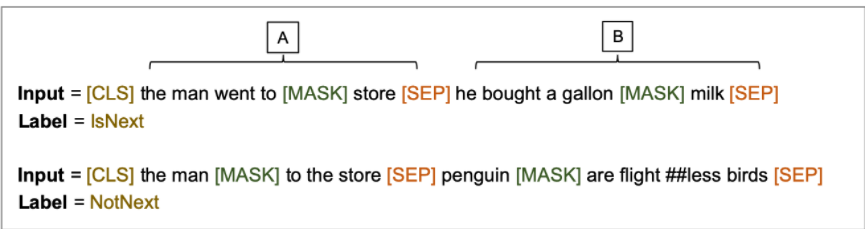

### NSP (Next Sentence Prediction) pair 생성

In [ ]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [ ]:
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전']]

In [ ]:
n_test_seq = 64
min_seq = 8
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_test_seq -3

In [ ]:
current_chunk = []
current_length = 0
for i in range(len(doc)): 
    current_chunk.append(doc[i]) # line단위로 추가
    current_length += len(doc[i]) # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) -1 or current_length >= max_seq): #마지막 줄이거나 길이가 max_seq 이상인 경우
        print('current_chunk:', len(current_chunk), current_length, current_chunk)

        #######
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])

        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
        #######  
        
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        print()

        current_chunk = []
        current_length = 0

current_chunk: 6 70 [['▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전'], ['▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러'], ['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔']]
tokens_a: 46 ['▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에']
tokens_b: 24 ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔']

current_chunk: 6 74 [['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한'

In [ ]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break
        
        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [ ]:
current_chunk = []
current_length = 0
for i in range(len(doc)): 
    current_chunk.append(doc[i]) # line단위로 추가
    current_length += len(doc[i]) # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) -1 or current_length >= max_seq): #마지막 줄이거나 길이가 max_seq 이상인 경우
        print('current_chunk:', len(current_chunk), current_length, current_chunk)

        #######
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])

        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
        #######  

        if random.random() < 0.5: # 50% 확률로 swap
            is_next = 0
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_nest = 1
        # max_seq보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next :", is_next)
        
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        print()

        current_chunk = []
        current_length = 0

current_chunk: 6 70 [['▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전'], ['▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러'], ['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔']]
is_next : 0
tokens_a: 10 ['▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어']
tokens_b: 51 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한']

current_chunk: 6 74 [['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '▁살', '

In [ ]:
# 두 문장들 사이에 segment 처리
# 첫 문장의 segment는 모두 0으로, 두 번째 문장은 1로 채워준 후 둘 사이의 구분자 [SEP] 삽입

instances = []
current_chunk = []
current_length = 0
for i in range(len(doc)): 
    current_chunk.append(doc[i]) # line단위로 추가
    current_length += len(doc[i]) # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) -1 or current_length >= max_seq): #마지막 줄이거나 길이가 max_seq 이상인 경우
        print('current_chunk:', len(current_chunk), current_length, current_chunk)

        #######
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])

        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
        #######  

        if random.random() < 0.5: # 50% 확률로 swap
            is_next = 0
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_nest = 1
        # max_seq보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next :", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)

        #####
        # tokens & segment 생성
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["SEP"]
        segment = [0] * (len(tokens_a) +2) + [1] * (len(tokens_b) +1)
        print("tokens :", len(tokens), tokens)
        print("segment :", len(segment), segment)

        # mask
        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens)-3)* 0.15), vocab_list)
        print("masked tokens :", len(tokens), tokens)
        print("masked index :", len(mask_idx), mask_idx)
        print("masked label :", len(mask_label), mask_label)

        instance = {
            "tokens" : tokens,
            "segment" : segment,
            "is_next" : is_next,
            "mask_idx": mask_idx,
            "mask_label" : mask_label
        }
        instances.append(instance)


        print()

        current_chunk = []
        current_length = 0


current_chunk: 6 70 [['▁추', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전'], ['▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러'], ['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔']]
is_next : 0
tokens_a: 31 ['적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전']
tokens_b: 30 ['▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목']
tokens : 64 ['[CLS]', '적', '추', '적', '▁비가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '[SE

In [ ]:
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '적', '추', '적', '[MASK]', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁표준', '▁첫', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '[SEP]', '[MASK]', '[MASK]', '▁받아', '보는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', 'SEP'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [4, 16, 17, 18, 19, 21, 22, 33, 34], 'mask_label': ['▁비가', '▁손', '님', '이', '▁많아', '▁번', '에', '▁오랜', '만에']}
{'tokens': ['[CLS]', '▁달', '▁포', '▁전', '부터', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '▁살', '▁수', '▁있어', '[SEP]', '▁집', '으로', '▁돌아', '가는', '▁길', '▁난', '▁문

### Next Sentence Prediction을 위한 코퍼스 생성 메소드

In [ ]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [ ]:
# 수행 결과 확인
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '끌', '[MASK]', '[MASK]', '[MASK]', '▁서', '푼', '에', '▁손', '바', '닥', '[MASK]', '[MASK]', '▁기', '쁨', '의', '▁발생한', '▁정착', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '[SEP]', '▁추', '적', '추', '적', '▁속에', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [1, 2, 3, 4, 11, 12, 16, 17, 37], 'mask_label': ['리', '▁백', '통', '화', '▁위', '엔', '▁눈', '물이', '▁비가']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁목소', '리가', '▁거', '칠', '어', '만', '[MASK]', '▁희', '박', '한', '▁숨', '소', '리가', '▁오늘', '은', '▁', '왠', '지', '▁나', '가지', '▁말', '라', '던', '▁내', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁몇', '▁달', '▁포', '▁전', '부터',

### 데이터셋 완성

In [ ]:
corpus_file = './kowiki.txt'

In [ ]:
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1
total

3724301

In [ ]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = [] # 단락 단위로 문서 저장
    for line in tqdm(in_f, total= total):
        line = line.strip()
        if line == "": # line이 빈줄 일 경우 (새로운 단락을 의미 함.)
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:
            pieces = vocab.encode_as_pieces(line)
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []

  0%|          | 103/3724301 [00:00<11:34, 5363.16it/s]

21 lines ['▁지', '미', '▁카', '터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니', '어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인권', '과', '▁중', '재', '▁역할', '에', '▁대한', '▁공', '로를', '▁인정', '받아', '▁노벨', '▁평화', '상을', '▁받게', '▁되었다', '.']

14 lines ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '▁은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미적분', '▁등의', '▁개념을', '▁다루는', '▁학문이다', '.', '▁현대', '▁수', '학은', '▁형식', '▁논', '리를', '▁이용', '해서', '▁공리', '로', '▁구성된', '▁추상', '적', '▁구조를', '▁연구하는', '▁학문', '으로', '▁여겨', '지기도', '▁한다', '.', '▁수', '학은', '▁그', '▁구조', '와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학문', '들과', '▁깊은', '▁연', '관을', '▁맺', '고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학의', '▁분야', '들과', '는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지', '▁않는', '▁개념', '들에', '▁대해서', '까지', '▁이론을', '▁일반화', '▁및', '▁추상', '화', '시킬', 

In [ ]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리 함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 103/3724301 [00:00<11:51, 5237.54it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '[MASK]', '▁분석', '에', '▁있어서', '▁매우', '[MASK]', '▁방법으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '▁합성', '섬', '유', '등의', '▁고', '분', '자', '물질', '▁등도', '▁유기', '화', '학에서', '▁다루', '어', '진다', '.', '[SEP]', '▁유기', '화', '학은', '[MASK]', '[MASK]', '[MASK]', '▁이루어진', '▁화합', '물을', '하지', '▁분', '과', '이다', '.', '▁원래', '▁유기', '▁화합', '물은', '▁식물', '이나', '[MASK]', '[MASK]', '▁추', '출', '해', '낸', '▁화합', '물을', '▁뜻', '하였으나', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [1, 5, 6, 36, 37, 38, 42, 53, 54], 'mask_label': ['물', '▁매우', '▁중요한', '▁탄', '소', '로', '▁연구하는', '▁동물', '로부터']}
{'tokens': ['[CLS]', '물', '▁분석', '에', '▁있어서', '[MASK]', '▁중요한', '▁방법으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '▁합성', '섬', '유', '등의', '▁저', '군', '졸', '물리', '▁등도', '▁유기', '화', '학에서', '▁다루', 

### BERT pretrain 데이터셋 생성 메소드

In [ ]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")
    
    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))
    
    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1
    
    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [ ]:
pretrain_json_path = './bert_pre_train.json'
make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

100%|██████████| 3724301/3724301 [06:26<00:00, 9639.10it/s] 


In [ ]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total # 862285

857431

In [ ]:
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [ ]:
# 만들어진 json파일을 라인 단위로 읽어들여 np.memmap에 로딩
# 라인단위로 처리
with open(pretrain_json_path, "r") as f:
    for i, line in enumerate(tqdm(f, total=total)):
        if 5 < i:  # 테스트를 위해서 5개만 확인
            break
        data = json.loads(line)
        # encoder token
        enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
        enc_token += [0] * (n_seq - len(enc_token))
        # segment
        segment = data["segment"]
        segment += [0] * (n_seq - len(segment))
        # nsp label
        label_nsp = data["is_next"]
        # mlm label
        mask_idx = np.array(data["mask_idx"], dtype=np.int)
        mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
        label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
        label_mlm[mask_idx] = mask_label

        print(data)
        print("enc_token:", enc_token)
        print("segment:", segment)
        print("label_nsp:", label_nsp)
        print("label_mlm:", label_mlm)
        print()

        assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

        enc_tokens[i] = enc_token
        segments[i] = segment
        labels_nsp[i] = label_nsp
        labels_mlm[i] = label_mlm

  0%|          | 6/857431 [00:00<1:08:07, 209.75it/s]

{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁카', '터', '▁제임스', '[MASK]', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니', '어', '(,', '▁1924', '년', '▁10', '월', '▁1', '일', '[MASK]', '[MASK]', '[MASK]', '▁민주당', '▁출신', '▁미국', '[MASK]', '[MASK]', '[MASK]', '▁대통령', '▁(19', '77', '년', '▁~', '▁1981', '년', ')', '이다', '.', '[SEP]', '▁지', '미', '▁카', '터', '는', '▁조지', '아', '주', '[MASK]', '[MASK]', '▁카', '운', '티', '▁플', '레', '인', '스', '▁마을', '에서', '▁태어났다', '.', '[MASK]', '[MASK]', '▁공', '과', '대학교', '를', '▁졸업', '하였다', '.', '▁그', '▁후', '▁해군', '에', '▁들어가', '▁전', '함', '·', '원', '자', '력', '·', '잠', '수', '함', '의', '▁승', '무', '원으로', '▁일', '하였다', '.', '▁1953', '년', '▁미국', '▁해군', '▁대', '위로', '▁예', '편', '하였고', '▁이후', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁등을', '▁가', '꿔', '▁많은', '▁돈을', '▁벌', '었다', '.', '▁그의', '▁별', '명이', '▁"', '땅', '콩', '▁농', '부', '"', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

### 학습에 필요한 데이터를 로딩하는 함수

In [ ]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [ ]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

100%|██████████| 128000/128000 [00:37<00:00, 3422.22it/s]

data load early stop 128000 128000


In [ ]:
# 처음과 마지막을 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1],

(memmap([   5,    6,    6,  489, 5697, 3620,    6,   93, 5607, 5688, 5687,
          489, 5697,   44, 5746, 5616, 1093, 5137, 5628,  180, 5682,    8,
         5620,    6,    6,    6, 1145, 1450,  235,    6,    6,    6,  281,
         3395, 3480, 5628, 1416, 4124, 5628, 5632,   28, 5594,    4,   24,
         5688,  489, 5697, 5595, 2156, 5638, 5640,    6,    6,  489, 5732,
         5908,  607, 5771, 5612, 5627, 3750,   11, 2747, 5594,    6,    6,
           41, 5626,  925, 5610, 1409,   49, 5594,   12,  115, 3454, 5596,
         3533,   21, 5754, 5834, 5659, 5619, 5750, 5834, 6253, 5615, 5754,
         5593,  647, 5741, 1790,   29,   49, 5594, 4851, 5628,  235, 3454,
           13, 2707,  169, 5853,  484,  161,    6,    6,    6,    6,    6,
          526,   19, 6975,  269, 4279, 1067,   27, 5594,  247,  745, 1356,
           93, 6331, 6343,  599, 5642, 5687,    4], dtype=int32),
 memmap([   5,   79, 5677, 5625,    4,   79, 5677, 5625, 1422, 5691, 5634,
         5628,  202, 5682,  330, 5

### BERT 모델 구현

In [ ]:
# 유틸리티 함수 구현
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [ ]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

In [ ]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [ ]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [ ]:
# token embedding
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [ ]:
# positional embedding 레이어 구현
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [ ]:
# scale dot product attention
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [ ]:
# 이를 활용한 multi head attention
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [ ]:
# transformer encoder 레이어 구현 시작
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [ ]:
# 최종 BERT 레이어
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [ ]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

In [ ]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [ ]:
# 아주 작은 pretrain용 BERT 모델을 생성해 동작 확인
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_ff': 1024,
 'd_head': 64,
 'd_model': 256,
 'dropout': 0.1,
 'i_pad': 0,
 'layernorm_epsilon': 0.001,
 'n_head': 4,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007}

In [ ]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 6s 28ms/step - loss: 9.7747 - nsp_loss: 0.7198 - mlm_loss: 9.0549 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 25ms/step - loss: 8.5973 - nsp_loss: 0.6165 - mlm_loss: 7.9808 - nsp_acc: 0.8000 - mlm_acc: 0.0000e+00


### Pretrain 진행

In [ ]:
# loss, accuracy 등 기본적으로 필요한 계산 함수 정의
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [ ]:
# learning rate scheduler 구현
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

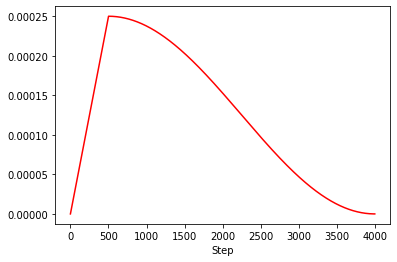

In [ ]:
# 스케줄러 테스트
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [ ]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 256),        4485632     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                            

In [ ]:
# 학습 (전체 데이터셋의 1/7 수준인 128000건만 사용)
epochs = 3
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 6000


In [ ]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/3
2000/2000 [==============================] - ETA: 0s - loss: 19.1951 - nsp_loss: 0.6415 - mlm_loss: 18.5535 - nsp_acc: 0.5982 - mlm_lm_acc: 0.1143
Epoch 00001: mlm_lm_acc improved from -inf to 0.11434, saving model to ./bert_pre_train.hdf5
2000/2000 [==============================] - 521s 259ms/step - loss: 19.1951 - nsp_loss: 0.6415 - mlm_loss: 18.5535 - nsp_acc: 0.5982 - mlm_lm_acc: 0.1143
Epoch 2/3
 367/2000 [====>.........................] - ETA: 7:01 - loss: 17.7322 - nsp_loss: 0.6197 - mlm_loss: 17.1126 - nsp_acc: 0.6264 - mlm_lm_acc: 0.1310

In [ ]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()